In [3]:
#########################################
# 1. IMPORT LIBRARIES & SET GLOBAL VARS #
#########################################

import os
from os.path import exists
import glob
import re
import sys
sys.path.append('../')


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import xarray as xr

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

# import gdown

# Threshold used for selecting reliable voxels.
NCSNR_THRESHOLD = 0.2


from PIL import Image

from sklearn.manifold import MDS
from sklearn.decomposition import PCA

from sklearn.linear_model import RidgeCV  # using RidgeCV with a fixed alpha
from sklearn.metrics import r2_score as r2_score_sklearn

import sys

import pickle

In [4]:
# Load Algonauts data

with open('../algonauts_brain_data_joint_images_8subjects.pkl', 'rb') as f:
    brainData = pickle.load(f)

shared_images = np.load('../algonauts_joint_images_8subjects.npy')

In [5]:
avail_models = models.list_models(module=torchvision.models)
avail_models

['alexnet',
 'convnext_base',
 'convnext_large',
 'convnext_small',
 'convnext_tiny',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'efficientnet_b0',
 'efficientnet_b1',
 'efficientnet_b2',
 'efficientnet_b3',
 'efficientnet_b4',
 'efficientnet_b5',
 'efficientnet_b6',
 'efficientnet_b7',
 'efficientnet_v2_l',
 'efficientnet_v2_m',
 'efficientnet_v2_s',
 'googlenet',
 'inception_v3',
 'maxvit_t',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_128gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'resnext50_32x4d',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'sh

In [8]:
# Extract representations resulting from probe inputs image_data for a list of models, and save them individually (takes a long time)

import extract_internal_reps

# internal_reps = []
# model_2nds = []
repDict = {}

model_names = avail_models[2:] #["alexnet"]
weights = 'random' #'first'
# image_data = test_image_data[0:1000,:,:,:]
image_data = shared_images
batch_size = 32

for model in model_names:  #avail_models:
    repDict = {}
    if model == 'vit_h_14':
        continue
    else:
        repDict[model + '_random'] = extract_internal_reps.get_model_activations(model, weights, image_data, batch_size=32, saverep = True, filename = 'algonauts_shared_images_random_weights')
        print(model + " done")

    del repDict

Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
convnext_large done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
convnext_small done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
convnext_tiny done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
classifier
conv0
norm0
relu0
pool0
denseblock1
transition1
denseblock2
transition2
denseblock3
transition3
denseblock4
norm5
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
densenet121 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
classifier
conv0
norm0
relu0
pool0
denseblock1
transition1
denseblock2
transition2
denseblock3
transition3
denseblock4
norm5
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
densenet161 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
classifier
conv0
norm0
relu0
pool0
denseblock1
transition1
denseblock2
transition2
denseblock3
transition3
denseblock4
norm5
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
densenet169 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
classifier
conv0
norm0
relu0
pool0
denseblock1
transition1
denseblock2
transition2
denseblock3
transition3
denseblock4
norm5
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
densenet201 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b0 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b1 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b2 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b3 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b4 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b5 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b6 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_b7 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_v2_l done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_v2_m done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
efficientnet_v2_s done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Using cuda for inference
conv1
maxpool1
conv2
conv3
maxpool2
inception3a
inception3b
maxpool3
inception4a
inception4b
inception4c
inception4d
inception4e
maxpool4
inception5a
inception5b
aux1
aux2
avgpool
dropout
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
googlenet done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Using cuda for inference
Conv2d_1a_3x3
Conv2d_2a_3x3
Conv2d_2b_3x3
maxpool1
Conv2d_3b_1x1
Conv2d_4a_3x3
maxpool2
Mixed_5b
Mixed_5c
Mixed_5d
Mixed_6a
Mixed_6b
Mixed_6c
Mixed_6d
Mixed_6e
AuxLogits
Mixed_7a
Mixed_7b
Mixed_7c
avgpool
dropout
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
inception_v3 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /dev/shm/nix-build-py-torch-2.2.2.drv-0/nixbld1/spack-stage-py-torch-2.2.2-mrga1lajkybghn1l6sc83lyspvbakfzk/spack-src/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Using cuda for inference
stem
blocks
classifier
0
1
2
3
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
maxvit_t done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
layers
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
mnasnet0_5 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
layers
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
mnasnet0_75 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
layers
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
mnasnet1_0 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
layers
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
mnasnet1_3 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
mobilenet_v2 done
Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
mobilenet_v3_large done
Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
mobilenet_v3_small done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_x_16gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_x_1_6gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_x_32gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_x_3_2gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_x_400mf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_x_800mf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_x_8gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_128gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_16gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_1_6gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_32gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_3_2gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_400mf done
Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_800mf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
stem
trunk_output
avgpool
fc
block1
block2
block3
block4
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
regnet_y_8gf done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnet101 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnet152 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnet18 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnet34 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnet50 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnext101_32x8d done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnext101_64x4d done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
resnext50_32x4d done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
maxpool
stage2
stage3
stage4
conv5
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
shufflenet_v2_x0_5 done
Using cuda for inference
conv1
maxpool
stage2
stage3
stage4
conv5
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
shufflenet_v2_x1_0 done
Using cuda for inference
conv1
maxpool
stage2
stage3
stage4
conv5
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
shufflenet_v2_x1_5 done
Using cuda for inference
conv1
maxpool
stage2
stage3
stage4
conv5
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
shufflenet_v2_x2_0 done
Using cuda for inference
features
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
squeezenet1_0 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
squeezenet1_1 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
norm
permute
avgpool
flatten
head
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
swin_b done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
norm
permute
avgpool
flatten
head
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
swin_s done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
norm
permute
avgpool
flatten
head
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
swin_t done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
norm
permute
avgpool
flatten
head
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
swin_v2_b done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
norm
permute
avgpool
flatten
head
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
swin_v2_s done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
norm
permute
avgpool
flatten
head
0
1
2
3
4
5
6
7
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
swin_v2_t done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg11 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg11_bn done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg13 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg13_bn done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg16 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg16_bn done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg19 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
features
avgpool
classifier
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vgg19_bn done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv_proj
encoder
heads
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vit_b_16 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv_proj
encoder
heads
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vit_b_32 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv_proj
encoder
heads
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vit_l_16 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv_proj
encoder
heads
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
vit_l_32 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
wide_resnet101_2 done


Using cache found in /mnt/home/sharvey/.cache/torch/hub/pytorch_vision_main


Using cuda for inference
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
This model does not provide a transforms() method for preprocessing.  Using default.
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
wide_resnet50_2 done


In [12]:
# Load some saved representations

repDict = {}

model_names = ["alexnet", "resnet50", "vit_b_16"] #avail_models
# model_names.remove("vit_h_14") #["alexnet", "resnet50", "vit_b_16"]

N_models = len(model_names)
for model_name in model_names:
    with open('../reps/' + model_name + '_algonauts_shared_images.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict.update(new_reps)
        print(model_name)

# model_names, _ = zip(*repDict.items())
model_names = [value for value in repDict.keys()]
# internal_reps = [value[0] for value in repDict.values()]


layer_names = []
internal_reps = []
layer_models = []

for model_name in model_names:
    layer_names.extend([value for value in repDict[model_name].keys()])
    internal_reps.extend([value for value in repDict[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict[model_name].keys()]))

alexnet
convnext_base
convnext_large
convnext_small
convnext_tiny
densenet121


KeyboardInterrupt: 

In [48]:
# Choose subject and target brain region


# areas = ['lh_FFA-1', 'rh_FFA-1', 'lh_FFA-2', 'rh_FFA-2']
# areas = ['lh_all-faces', 'rh_all-faces']
# areas = ['lh_all-words', 'rh_all-words']
# areas = ["lh_V1v", "rh_V1v", "lh_V1d", "rh_V1d"]
# areas = ['lh_OWFA', 'rh_OWFA']
# areas_both_hemi = ["OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces"] 

subjind = 0
hemisphere = "both"  # lh, rh, or both
areas_to_append = ["FFA-1"] 


areas = []
for area in areas_to_append:
    if hemisphere == "both":
        areas.append('lh_' + area)
        areas.append('rh_' + area)
    elif hemisphere == "lh":
        areas.append('lh_' + area)
    elif hemisphere == "rh":
        areas.append('rh_' + area)

# all_areas = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]

brain_target = brainData[0][areas[0]]
for area in areas[1:]:
    brain_target = np.append(brain_target, brainData[0][area],axis=1)

In [49]:
# Make sure representations are flattened

internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]

[internal_rep.shape for internal_rep in internal_reps]

[(872, 541875),
 (872, 193600),
 (872, 193600),
 (872, 46656),
 (872, 139968),
 (872, 139968),
 (872, 32448),
 (872, 64896),
 (872, 64896),
 (872, 43264),
 (872, 43264),
 (872, 43264),
 (872, 43264),
 (872, 9216),
 (872, 9216),
 (872, 9216),
 (872, 1000),
 (872, 541875),
 (872, 802816),
 (872, 802816),
 (872, 802816),
 (872, 200704),
 (872, 802816),
 (872, 401408),
 (872, 200704),
 (872, 100352),
 (872, 2048),
 (872, 1000),
 (872, 541875),
 (872, 150528),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 151296),
 (872, 1000)]

In [71]:
# Separate into train and test sets

internal_reps_train = [internal_rep[0:436] for internal_rep in internal_reps]
internal_reps_test = [internal_rep[436:] for internal_rep in internal_reps]
brain_target_train = brain_target[0:436]
brain_target_test = brain_target[436:]

In [ ]:
# Implement ridge regression and compute R^2 score for the particular model layers and particular brain area

In [72]:
alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e7]

bestScores = {}

for model_name in model_names:

    print(model_name)

    scores = []

    for i in range(len(internal_reps)):

        if layer_models[i] == model_name:

            Xtrain = internal_reps_train[i]
            ytrain = brain_target_train

            Xtest = internal_reps_test[i]
            ytest = brain_target_test

            clf = RidgeCV(alphas=alphas).fit(Xtrain, ytrain)
            scores.append(clf.score(Xtest, ytest))
            print(i)
        else:
            continue

    bestind = int(np.argmax(scores))

    bestScores[model_name] = [list(repDict[model_name].keys())[bestind], scores[bestind] ]


# clf.predict(Xtest)

alexnet
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
resnet50
17
18
19
20
21
22
23
24
25
26
27
vit_b_16
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43


In [73]:
bestScores

{'alexnet': ['feature.12', 0.17273218158595455],
 'resnet50': ['layer3', 0.1730730631140099],
 'vit_b_16': ['encoder', 0.14308709373932468]}

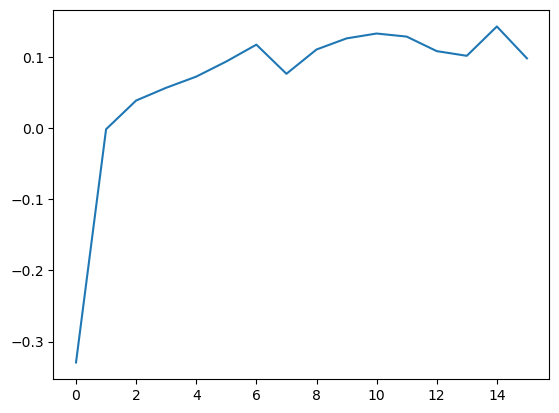

In [75]:
plt.plot(scores)

In [65]:
subjind = 0
hemisphere = "both"  # lh, rh, or both
areas_to_append = ["V1v"] 


areas = []
for area in areas_to_append:
    if hemisphere == "both":
        areas.append('lh_' + area)
        areas.append('rh_' + area)
    elif hemisphere == "lh":
        areas.append('lh_' + area)
    elif hemisphere == "rh":
        areas.append('rh_' + area)

# all_areas = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]

brain_target = brainData[subjind][areas[0]]
for area in areas[1:]:
    brain_target = np.append(brain_target, brainData[subjind][area],axis=1)

In [74]:
subjind = 7
hemisphere = "both"  # lh, rh, or both
areas_to_append = ["V1v"] 


areas = []
extra_brain = []
for area in areas_to_append:
    if hemisphere == "both":
        areas.append('lh_' + area)
        areas.append('rh_' + area)
    elif hemisphere == "lh":
        areas.append('lh_' + area)
    elif hemisphere == "rh":
        areas.append('rh_' + area)

# all_areas = ["V1v", "V1d", "V2v", "V2d", "V3v", "V3d", "hV4", "EBA", "FBA-1", "FBA-2", "mTL-bodies", "OFA", "FFA-1", "FFA-2", "mTL-faces", "aTL-faces", "OPA", "PPA", "RSC", "OWFA", "VWFA-1", "VWFA-2", "mfs-words", "mTL-words", "early", "midventral", "midlateral", "midparietal", "ventral", "lateral", "parietal", "all-prf-visual", "all-bodies", "all-faces", "all-places", "all-words", "all-streams"]

extra_brain = brainData[subjind][areas[0]]
for area in areas[1:]:
    extra_brain = np.append(extra_brain, brainData[subjind][area],axis=1)

In [46]:
# bestScores = {}
# with open('bestScores_V1v_both.pkl', 'wb') as f:
#     pickle.dump(bestScores, f)

In [75]:
# A better way

# Load a saved representation

model_names = ['subject_7'] #avail_models
# model_names.remove("vit_h_14") #["alexnet", "resnet50", "vit_b_16"]

N_models = len(model_names)

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e7]

bestScores_update = {}


for model_name in model_names:
    repDict = {}
#     with open('../reps/' + model_name + '_algonauts_shared_images.pkl', 'rb') as f:
#         new_reps = pickle.load(f)
#         repDict.update(new_reps)
#         print("loaded " + model_name)
    repDict[model_name] = {"V1v": extra_brain}
    



    # model_names, _ = zip(*repDict.items())
    # model_names = [value for value in repDict.keys()]
    # internal_reps = [value[0] for value in repDict.values()]
    
    
    layer_names = []
    internal_reps = []
    layer_models = []
    
    # for model_name in model_names:
    layer_names.extend([value for value in repDict[model_name].keys()])
    internal_reps.extend([value for value in repDict[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict[model_name].keys()]))

    
    # Make sure representations are flattened
    
    internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]
    
    [internal_rep.shape for internal_rep in internal_reps]

    # Separate into train and test sets

    internal_reps_train = [internal_rep[0:436] for internal_rep in internal_reps]
    internal_reps_test = [internal_rep[436:] for internal_rep in internal_reps]
    brain_target_train = brain_target[0:436]
    brain_target_test = brain_target[436:]

    print(model_name + " prepped")

    scores = []

    for i in range(len(internal_reps)):

        if layer_models[i] == model_name:

            Xtrain = internal_reps_train[i]
            ytrain = brain_target_train

            Xtest = internal_reps_test[i]
            ytest = brain_target_test

            clf = RidgeCV(alphas=alphas).fit(Xtrain, ytrain)
            scores.append(clf.score(Xtest, ytest))
            print(i)
        else:
            continue

    bestind = int(np.argmax(scores))

    bestScores_update[model_name] = [list(repDict[model_name].keys())[bestind], scores[bestind] ]

    with open('bestScores_V1v_both.pkl', 'rb') as f:
        bestScores = pickle.load(f)
        bestScores.update(bestScores_update)

    with open('bestScores_V1v_both.pkl', 'wb') as f:
        pickle.dump(bestScores, f)

    print(model_name + " done")
    
    del repDict


subject_7 prepped
0
subject_7 done


In [9]:
# A better way

# Load a saved representation

model_names = avail_models[-2:]
# model_names.remove("vit_h_14") #["alexnet", "resnet50", "vit_b_16"]

N_models = len(model_names)

alphas = [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1, 10, 100, 1000, 10000, 1e5, 1e6, 1e7, 1e7]

bestScores_update = {}


for model_name in model_names:
    repDict = {}
    with open('../reps/' + model_name + '_algonauts_shared_images_random_weights.pkl', 'rb') as f:
        new_reps = pickle.load(f)
        repDict.update(new_reps)
        print("loaded " + model_name)

    # model_names, _ = zip(*repDict.items())
    # model_names = [value for value in repDict.keys()]
    # internal_reps = [value[0] for value in repDict.values()]
    
    
    layer_names = []
    internal_reps = []
    layer_models = []
    
    # for model_name in model_names:
    layer_names.extend([value for value in repDict[model_name].keys()])
    internal_reps.extend([value for value in repDict[model_name].values()])
    layer_models.extend([model_name] * len([value for value in repDict[model_name].keys()]))

    
    # Make sure representations are flattened
    
    internal_reps = [internal_reps[i].reshape((internal_reps[i].shape[0], np.prod(list(internal_reps[i].shape[1:])) )) for i in range(len(internal_reps))]
    
    [internal_rep.shape for internal_rep in internal_reps]

    # Separate into train and test sets

    internal_reps_train = [internal_rep[0:436] for internal_rep in internal_reps]
    internal_reps_test = [internal_rep[436:] for internal_rep in internal_reps]
    brain_target_train = brain_target[0:436]
    brain_target_test = brain_target[436:]

    print(model_name + " prepped")

    scores = []

    for i in range(len(internal_reps)):

        if layer_models[i] == model_name:

            Xtrain = internal_reps_train[i]
            ytrain = brain_target_train

            Xtest = internal_reps_test[i]
            ytest = brain_target_test

            clf = RidgeCV(alphas=alphas).fit(Xtrain, ytrain)
            scores.append(clf.score(Xtest, ytest))
            print(i)
        else:
            continue

    bestind = int(np.argmax(scores))

    bestScores_update[model_name + '_random'] = [list(repDict[model_name].keys())[bestind], scores[bestind] ]

    with open('bestScores_V1v_both.pkl', 'rb') as f:
        bestScores = pickle.load(f)
        bestScores.update(bestScores_update)

    with open('bestScores_V1v_both.pkl', 'wb') as f:
        pickle.dump(bestScores, f)

    print(model_name + " done")
    
    del repDict


loaded wide_resnet101_2
wide_resnet101_2 prepped
0
1
2
3
4
5
6
7
8
9
10
wide_resnet101_2 done
loaded wide_resnet50_2
wide_resnet50_2 prepped
0
1
2
3
4
5
6
7
8
9
10
wide_resnet50_2 done


In [76]:
with open('bestScores_V1v_both.pkl', 'rb') as f:
    saved_scores = pickle.load(f)

saved_scores

{'alexnet': ['feature.2', 0.21081742671515036],
 'convnext_base': ['feature.1', 0.24414798025258616],
 'convnext_large': ['feature.1', 0.2272029323199508],
 'convnext_small': ['feature.3', 0.22214211570437653],
 'convnext_tiny': ['feature.3', 0.22743995722533336],
 'densenet121': ['feature.transition1', 0.23541096918901686],
 'densenet161': ['feature.transition1', 0.2416425824103204],
 'densenet169': ['feature.transition1', 0.2385454497335901],
 'densenet201': ['feature.transition1', 0.2352373121453848],
 'efficientnet_b0': ['feature.3', 0.22602563362471528],
 'efficientnet_b1': ['feature.3', 0.22637058095146448],
 'efficientnet_b2': ['feature.3', 0.2164318608024809],
 'efficientnet_b3': ['feature.4', 0.2144370420098996],
 'efficientnet_b4': ['feature.4', 0.22019426849335919],
 'efficientnet_b5': ['feature.4', 0.21416203389122876],
 'efficientnet_b6': ['feature.4', 0.20600278486745868],
 'efficientnet_b7': ['feature.4', 0.2004906189480244],
 'efficientnet_v2_l': ['feature.4', 0.2164607

In [77]:
scores = []
for model in saved_scores.keys():
    scores.append(saved_scores[model][1])

Text(0, 0.5, 'Number of models')

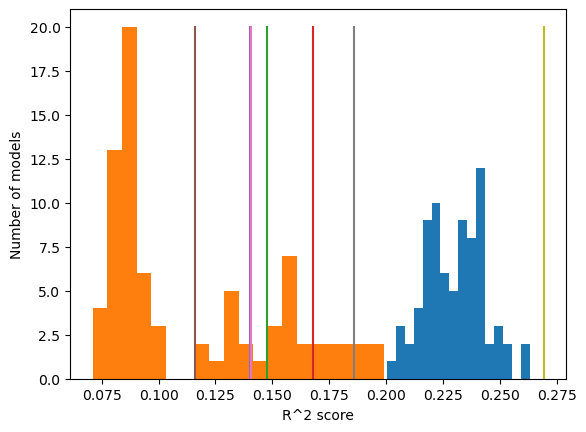

In [84]:
plt.hist(scores[:79],20)
plt.hist(scores[79:-7],20)
plt.plot( [scores[-1], scores[-1]],[0, 20])
plt.plot( [scores[-2], scores[-2]],[0, 20])
plt.plot( [scores[-3], scores[-3]],[0, 20])
plt.plot( [scores[-4], scores[-4]],[0, 20])
plt.plot( [scores[-5], scores[-5]],[0, 20])
plt.plot( [scores[-6], scores[-6]],[0, 20])
plt.plot( [scores[-7], scores[-7]],[0, 20])


plt.xlabel('R^2 score')
plt.ylabel('Number of models')

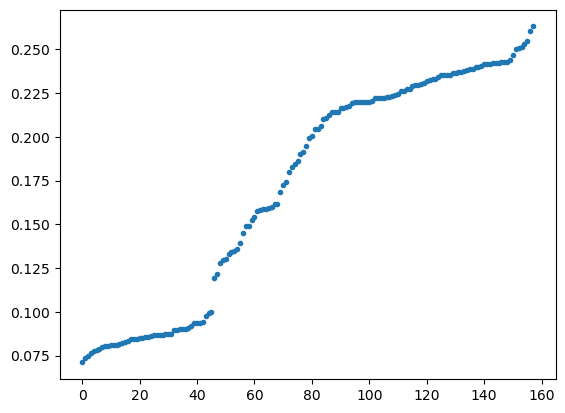

In [32]:
plt.plot(np.sort(scores),'.')

In [ ]:
# To do:
# - noise ceiling normalization
# - normalize by how well humans predict each other 